In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [25]:
# Load the data
transaction_data = pd.read_excel(r'/workspaces/quantium/resources/QVI_transaction_data.xlsx')
purchase_behaviour = pd.read_csv(r'/workspaces/quantium/resources/QVI_purchase_behaviour.csv')

In [26]:
# Change the DATE column to datetime format
transaction_data['DATE'] = pd.to_datetime(pd.to_numeric(transaction_data['DATE'], errors='coerce'), unit='D', origin='1899-12-30')

# Remove digits and special characters from PROD_NAME
# df['PROD_NAME'] = df['PROD_NAME'].str.replace('[0-9&]+', '', regex=True)

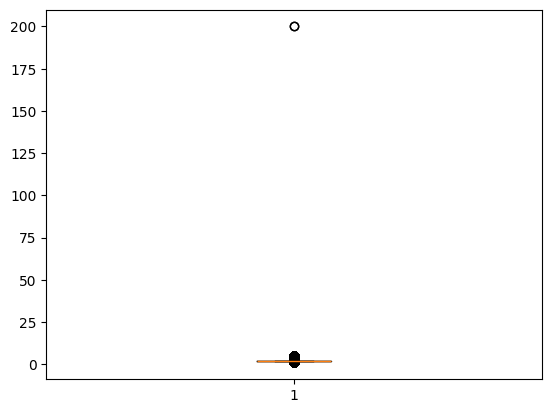

In [27]:
# Find the outliers
plt.boxplot(transaction_data['PROD_QTY'])
plt.show()

# Handle outliers in PROD_QTY column
from scipy import stats

z_scores = stats.zscore(transaction_data['PROD_QTY'])
transaction_data = transaction_data[(z_scores < 3) & (z_scores > -3)]

In [28]:
# Create a new row for December 25th, 2018 with specified values
row_25_dec = {'DATE': '2018-12-25', 'PROD_QTY': 0, 'TOT_SALES': 0}
# Fill other columns with '-'
for col in transaction_data.columns:
    if col not in row_25_dec:
        row_25_dec[col] = '-'

# Append the new row to the dataframe
transaction_data = pd.concat([transaction_data, pd.DataFrame([row_25_dec])], ignore_index=True)

# Sort the dataframe by date to integrate the new row in the correct chronological position
transaction_data['DATE'] = pd.to_datetime(transaction_data['DATE'], errors='coerce')
transaction_data.sort_values(by='DATE', inplace=True)

# Reset index after the sort
transaction_data.reset_index(drop=True, inplace=True)

# Check if the row is added
row_added = transaction_data[transaction_data['DATE'] == '2018-12-25']
print(row_added)

             DATE STORE_NBR LYLTY_CARD_NBR TXN_ID PROD_NBR PROD_NAME  \
128876 2018-12-25         -              -      -        -         -   

        PROD_QTY  TOT_SALES  
128876         0        0.0  


Initial data findings for chips product category transactions

In [29]:
# Filter for 'Chip' or 'Chips' in the product name
chip_data = transaction_data[transaction_data['PROD_NAME'].str.contains('Chip|Chips', case=False, regex=True)]

# Extract year and month from the DATE column
chip_data['YEAR'] = chip_data['DATE'].dt.year
chip_data['MONTH'] = chip_data['DATE'].dt.month

# Group by year and month to get monthly transactions
monthly_transactions = chip_data.groupby(['YEAR', 'MONTH']).size().reset_index(name='TRANSACTIONS')

/tmp/ipykernel_111646/2566225091.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chip_data['YEAR'] = chip_data['DATE'].dt.year
/tmp/ipykernel_111646/2566225091.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chip_data['MONTH'] = chip_data['DATE'].dt.month


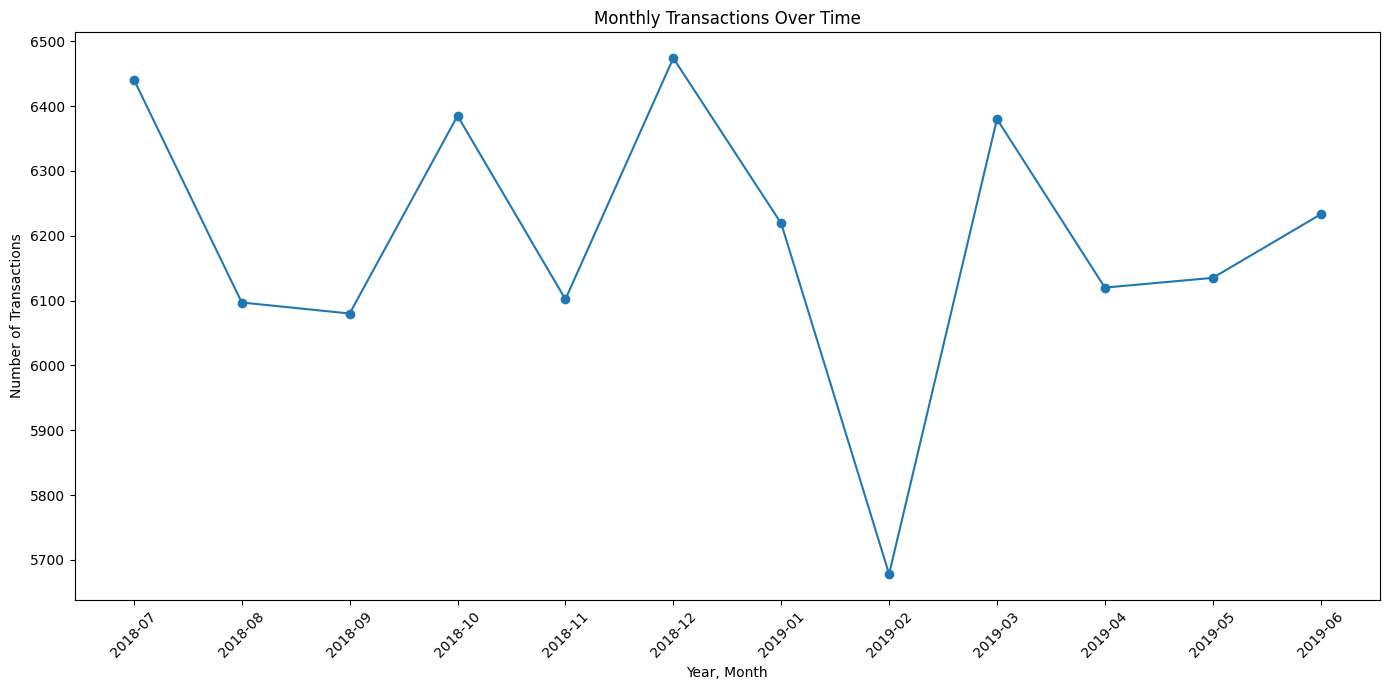

In [30]:
# Plotting the overall transactions over time
monthly_transactions['YEAR_MONTH'] = monthly_transactions['YEAR'].astype(str) + '-' + monthly_transactions['MONTH'].astype(str).str.zfill(2)

# Plotting the overall transactions over time
plt.figure(figsize=(14, 7))
plt.plot(monthly_transactions['YEAR_MONTH'], monthly_transactions['TRANSACTIONS'], marker='o')
plt.xlabel('Year, Month')
plt.ylabel('Number of Transactions')
plt.title('Monthly Transactions Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('/workspaces/quantium/output/monthly transactions.png')
plt.show()

/tmp/ipykernel_111646/3835653407.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chip_data['PACK_SIZE'] = chip_data['PROD_NAME'].apply(extract_pack_size)


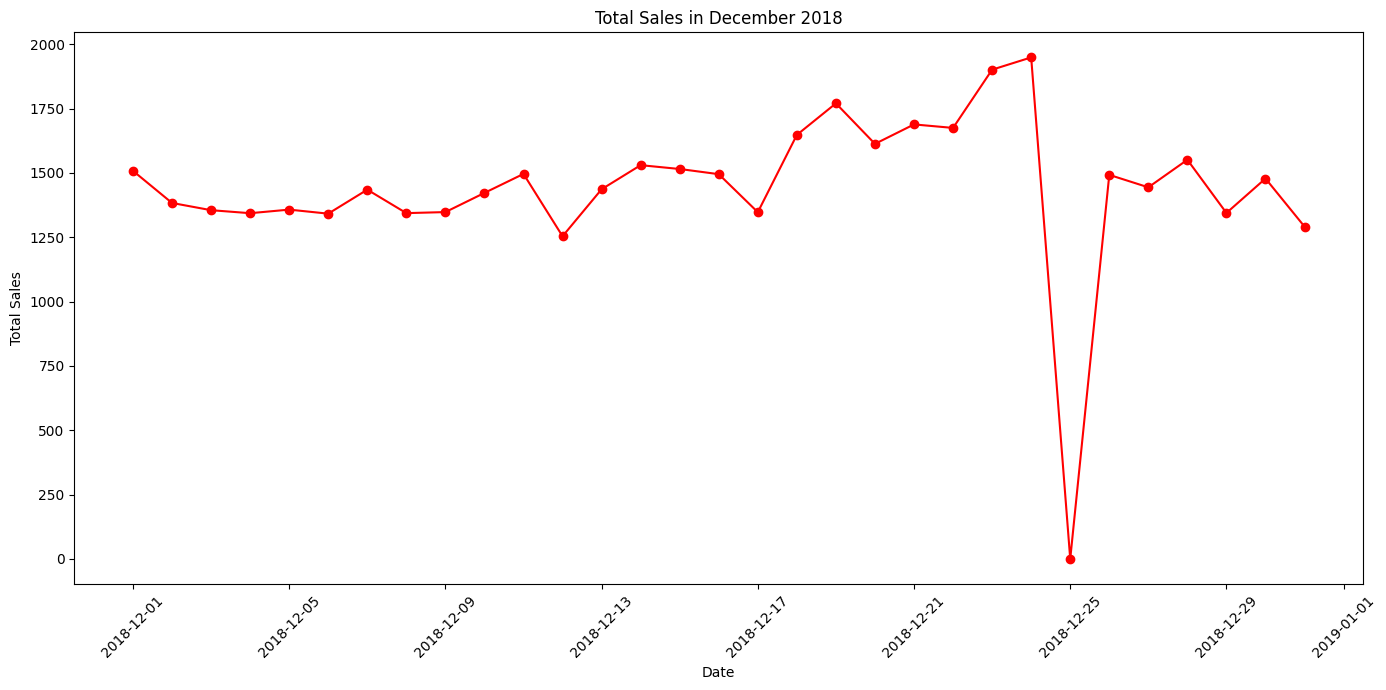

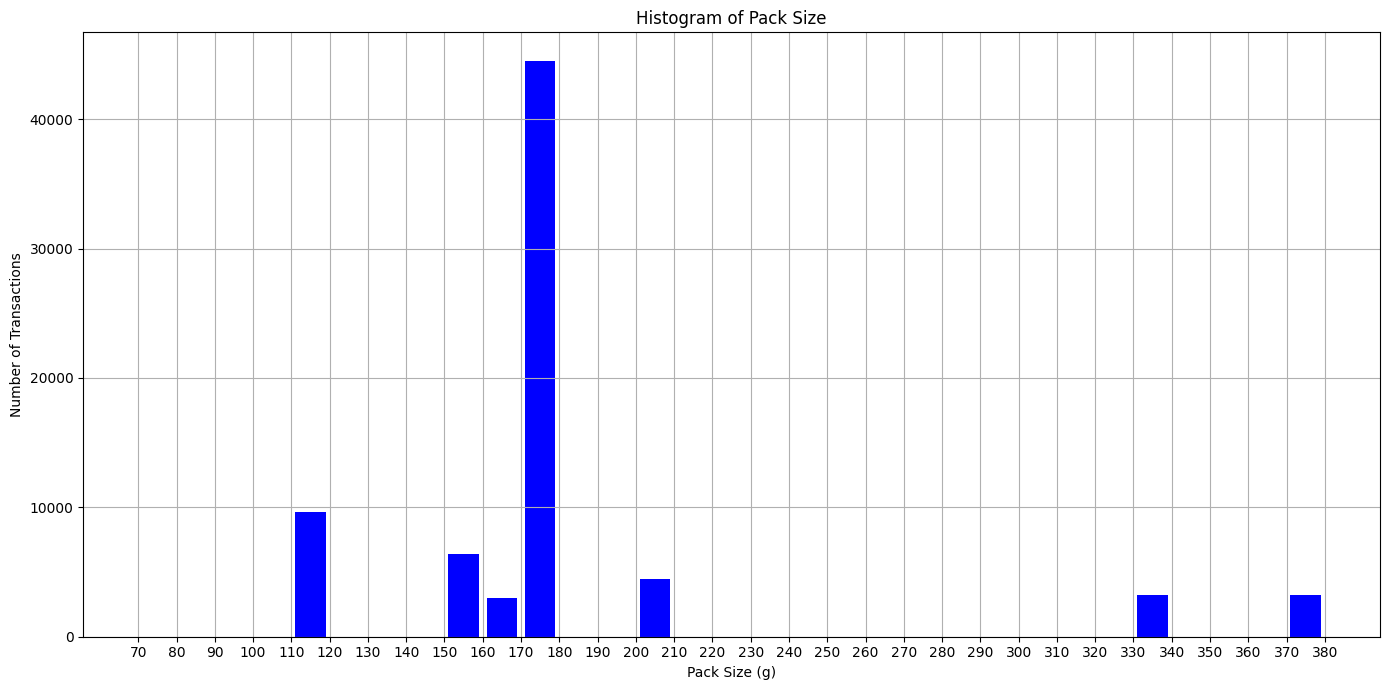

/tmp/ipykernel_111646/3835653407.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chip_data['BRAND'] = chip_data['PROD_NAME'].apply(lambda x: x.split(' ')[0])


(         DATE STORE_NBR LYLTY_CARD_NBR  TXN_ID PROD_NBR  \
 1  2018-07-01        20          20030   16975       90   
 2  2018-07-01       226         226185  227212       40   
 4  2018-07-01       231         231029  233803       28   
 10 2018-07-01       254         254106  254183       44   
 17 2018-07-01       209         209073  207890       96   
 
                                PROD_NAME  PROD_QTY  TOT_SALES  YEAR  MONTH  \
 1      Tostitos Smoked     Chipotle 175g         2        8.8  2018      7   
 2       Thins Chips Seasonedchicken 175g         2        6.6  2018      7   
 4   Thins Potato Chips  Hot & Spicy 175g         2        6.6  2018      7   
 10        Thins Chips Light&  Tangy 175g         1        3.3  2018      7   
 17        WW Original Stacked Chips 160g         2        3.8  2018      7   
 
     PACK_SIZE     BRAND  
 1         175  Tostitos  
 2         175     Thins  
 4         175     Thins  
 10        175     Thins  
 17        160        WW  ,

In [31]:
import re

# Function to extract pack size
def extract_pack_size(product_name):
    match = re.search('(\d+)', product_name)
    return int(match.group(1)) if match else None

# Apply the function to create the 'PACK_SIZE' column
chip_data['PACK_SIZE'] = chip_data['PROD_NAME'].apply(extract_pack_size)

# Filter for December 2018
december_2018_sales = chip_data[(chip_data['YEAR'] == 2018) & (chip_data['MONTH'] == 12)]

# Create a DataFrame with all dates in December 2018 
dates = pd.DataFrame({'DATE': pd.date_range('2018-12-01', '2018-12-31')})

# Merge with the sales data to include missing dates
december_2018_sales = pd.merge(dates, december_2018_sales, how='left', on='DATE')

# Fill missing sales with 0
december_2018_sales['TOT_SALES'] = december_2018_sales['TOT_SALES'].fillna(0)

# Summarize and plot
december_2018_summary = december_2018_sales.groupby('DATE')['TOT_SALES'].sum().reset_index()

plt.figure(figsize=(14, 7))
plt.plot(december_2018_summary['DATE'], december_2018_summary['TOT_SALES'], marker='o', color='red')
plt.title('Total Sales in December 2018') 
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('/workspaces/quantium/output/total sales december 2018.png')
plt.show()

# Plot a histogram of PACK_SIZE
plt.figure(figsize=(14, 7))
chip_data['PACK_SIZE'].hist(bins=range(70, 381, 10), color='blue', rwidth=0.8)
plt.title('Histogram of Pack Size')
plt.xlabel('Pack Size (g)')
plt.ylabel('Number of Transactions')
plt.xticks(range(70, 381, 10))
plt.tight_layout()
plt.savefig('/workspaces/quantium/output/pack size histogram.png')
plt.show()

# Create a new column for brand name
chip_data['BRAND'] = chip_data['PROD_NAME'].apply(lambda x: x.split(' ')[0])

(chip_data.head(), december_2018_summary.head())


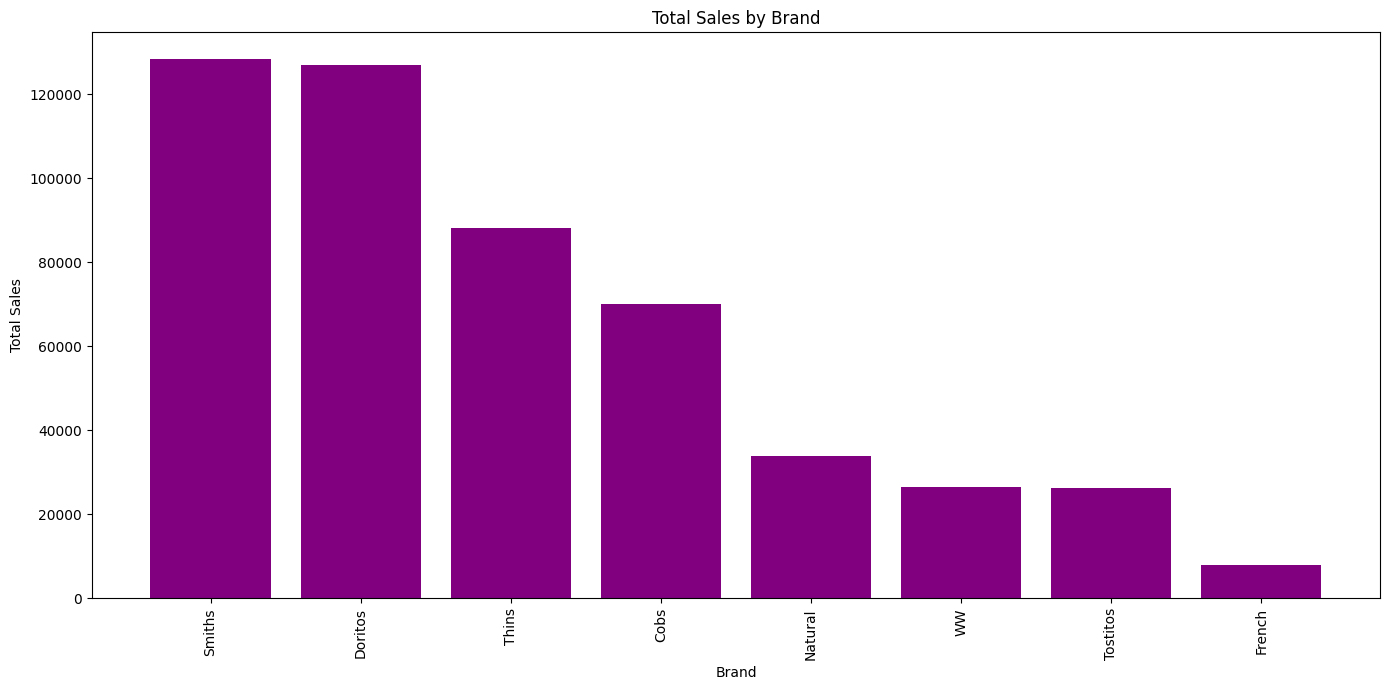

,BRAND,Total_Sales,Transactions
4,Smiths,128263.2,16812
1,Doritos,126844.8,15827
5,Thins,88152.9,14025
0,Cobs,70148.0,9668
3,Natural,33957.0,6027


In [32]:
# Group by brand and summarize total sales and transactions
brand_performance = chip_data.groupby('BRAND').agg(Total_Sales=('TOT_SALES', 'sum'), Transactions=('TXN_ID', 'nunique')).reset_index()

# Sort by total sales
brand_performance_sorted = brand_performance.sort_values(by='Total_Sales', ascending=False)

# Plotting brand performance
plt.figure(figsize=(14, 7))
plt.bar(brand_performance_sorted['BRAND'], brand_performance_sorted['Total_Sales'], color='purple')
plt.title('Total Sales by Brand')
plt.xlabel('Brand')
plt.ylabel('Total Sales')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('/workspaces/quantium/output/total sales by brand.png')
plt.show()

# Top 5 Brand by total sales and transaction
brand_performance_sorted.head()

In [33]:
# Continue with customer analysis
# Merge the customer data with the transaction data on the loyalty card number
data_merged = chip_data.merge(purchase_behaviour, on='LYLTY_CARD_NBR', how='left')

# Check the first few rows of the merged dataframe
merged_head = data_merged.head()

# Check the data types and missing values
customer_info = data_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74344 entries, 0 to 74343
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   DATE              74344 non-null  datetime64[ns]
 1   STORE_NBR         74344 non-null  object        
 2   LYLTY_CARD_NBR    74344 non-null  object        
 3   TXN_ID            74344 non-null  object        
 4   PROD_NBR          74344 non-null  object        
 5   PROD_NAME         74344 non-null  object        
 6   PROD_QTY          74344 non-null  int64         
 7   TOT_SALES         74344 non-null  float64       
 8   YEAR              74344 non-null  int32         
 9   MONTH             74344 non-null  int32         
 10  PACK_SIZE         74344 non-null  int64         
 11  BRAND             74344 non-null  object        
 12  LIFESTAGE         74344 non-null  object        
 13  PREMIUM_CUSTOMER  74344 non-null  object        
dtypes: datetime64[ns](1), 

In [34]:
# Segment customers based on 'LIFESTAGE' and 'PREMIUM_CUSTOMER' and calculate key metrics
segmented_data = data_merged.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).agg({'TOT_SALES': ['sum', 'mean'], 'PROD_QTY': 'sum', 'TXN_ID': 'nunique'}).reset_index()
segmented_data.columns = ['LIFESTAGE', 'PREMIUM_CUSTOMER', 'TOTAL_SALES', 'AVERAGE_SALES', 'TOTAL_QUANTITY', 'TRANSACTION_COUNT']

# Calculate purchase frequency for each segment
segmented_data['PURCHASE_FREQ'] = segmented_data['TRANSACTION_COUNT'] / data_merged['LYLTY_CARD_NBR'].nunique()

# Identify the top-performing segments in terms of sales and quantity
top_sales_segments = segmented_data.sort_values(by='TOTAL_SALES', ascending=False).head()
top_quantity_segments = segmented_data.sort_values(by='TOTAL_QUANTITY', ascending=False).head()

# Output the top-performing segments for sales and quantity
print(top_sales_segments)
print(top_quantity_segments)

                LIFESTAGE PREMIUM_CUSTOMER  TOTAL_SALES  AVERAGE_SALES  \
6          OLDER FAMILIES           Budget      44567.6       6.836570   
13               RETIREES       Mainstream      40343.1       6.788339   
19  YOUNG SINGLES/COUPLES       Mainstream      39956.2       7.089461   
15         YOUNG FAMILIES           Budget      36807.0       6.830024   
9   OLDER SINGLES/COUPLES           Budget      35642.8       6.914219   

    TOTAL_QUANTITY  TRANSACTION_COUNT  PURCHASE_FREQ  
6            12616               6501       0.149273  
13           11144               5941       0.136415  
19           10429               5628       0.129228  
15           10382               5379       0.123510  
9             9790               5147       0.118183  
                LIFESTAGE PREMIUM_CUSTOMER  TOTAL_SALES  AVERAGE_SALES  \
6          OLDER FAMILIES           Budget      44567.6       6.836570   
13               RETIREES       Mainstream      40343.1       6.788339   
19 

In [48]:
# Filter the transaction data for chip products only
chip_products = data_merged[data_merged['PROD_NAME'].str.contains('Chips|Chip', regex=True)]

# Analyze product preferences within the top-performing segments
# We will look at the most popular products and their sales contribution within each segment
chip_preferences = chip_products.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER', 'PROD_NAME', 'PACK_SIZE']).agg({'TOT_SALES': 'sum', 'PROD_QTY': 'sum'}).reset_index()

# Sort the preferences by total sales within each segment
top_chip_preferences = chip_preferences.sort_values(by=['LIFESTAGE', 'PREMIUM_CUSTOMER', 'TOT_SALES'], ascending=[True, True, False])

# Since the output might be long, we will display the top 5 chip products for the first segment as an example
example_segment = top_chip_preferences[(top_chip_preferences['LIFESTAGE'] == 'OLDER FAMILIES') & (top_chip_preferences['PREMIUM_CUSTOMER'] == 'Budget')].head()
print(example_segment)

          LIFESTAGE PREMIUM_CUSTOMER  \
214  OLDER FAMILIES           Budget   
219  OLDER FAMILIES           Budget   
203  OLDER FAMILIES           Budget   
205  OLDER FAMILIES           Budget   
225  OLDER FAMILIES           Budget   

                                    PROD_NAME  PACK_SIZE  TOT_SALES  PROD_QTY  
214  Smiths Crinkle Chips Salt & Vinegar 330g        330     3163.5       555  
219    Smiths Crnkle Chip  Orgnl Big Bag 380g        380     2991.3       507  
203   Doritos Corn Chips  Cheese Supreme 170g        170     2433.2       553  
205         Doritos Corn Chips  Original 170g        170     2103.2       478  
225         Tostitos Smoked     Chipotle 175g        175     2028.4       461  


In [49]:
# Now we will extend the analysis to all customer segments
# We will display the top 3 chip products for each customer segment by total sales

# Define a function to get the top products for each segment
def get_top_products(segment_data, num_top_products):
    return segment_data.groupby(['PROD_NAME', 'PACK_SIZE']).agg({'TOT_SALES': 'sum', 'PROD_QTY': 'sum'}).sort_values(by='TOT_SALES', ascending=False).head(num_top_products)

# Apply the function to each segment and store the results in a dictionary
segment_top_products = {}
for (lifestage, premium), group in chip_preferences.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']):
    segment_top_products[(lifestage, premium)] = get_top_products(group, 3)

# Display the top 3 products for each segment
for segment, top_products in segment_top_products.items():
    print(f'Segment: {segment}\
', top_products, '\
')

Segment: ('MIDAGE SINGLES/COUPLES', 'Budget')                                                    TOT_SALES  PROD_QTY
PROD_NAME                               PACK_SIZE                     
Smiths Crnkle Chip  Orgnl Big Bag 380g  380            613.6       104
Doritos Corn Chips  Cheese Supreme 170g 170            602.8       137
Doritos Corn Chip Southern Chicken 150g 150            518.7       133 
Segment: ('MIDAGE SINGLES/COUPLES', 'Mainstream')                                                     TOT_SALES  PROD_QTY
PROD_NAME                                PACK_SIZE                     
Smiths Crinkle Chips Salt & Vinegar 330g 330           2103.3       369
Smiths Crnkle Chip  Orgnl Big Bag 380g   380           1923.4       326
Doritos Corn Chips  Nacho Cheese 170g    170           1491.6       339 
Segment: ('MIDAGE SINGLES/COUPLES', 'Premium')                                                   TOT_SALES  PROD_QTY
PROD_NAME                              PACK_SIZE                     


/tmp/ipykernel_111646/1607921424.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='LIFESTAGE', y='PACK_SIZE', data=pack_size_by_lifestage, palette="viridis")
/home/codespace/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/codespace/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/codespace/.local/lib/python3.10/site-packag

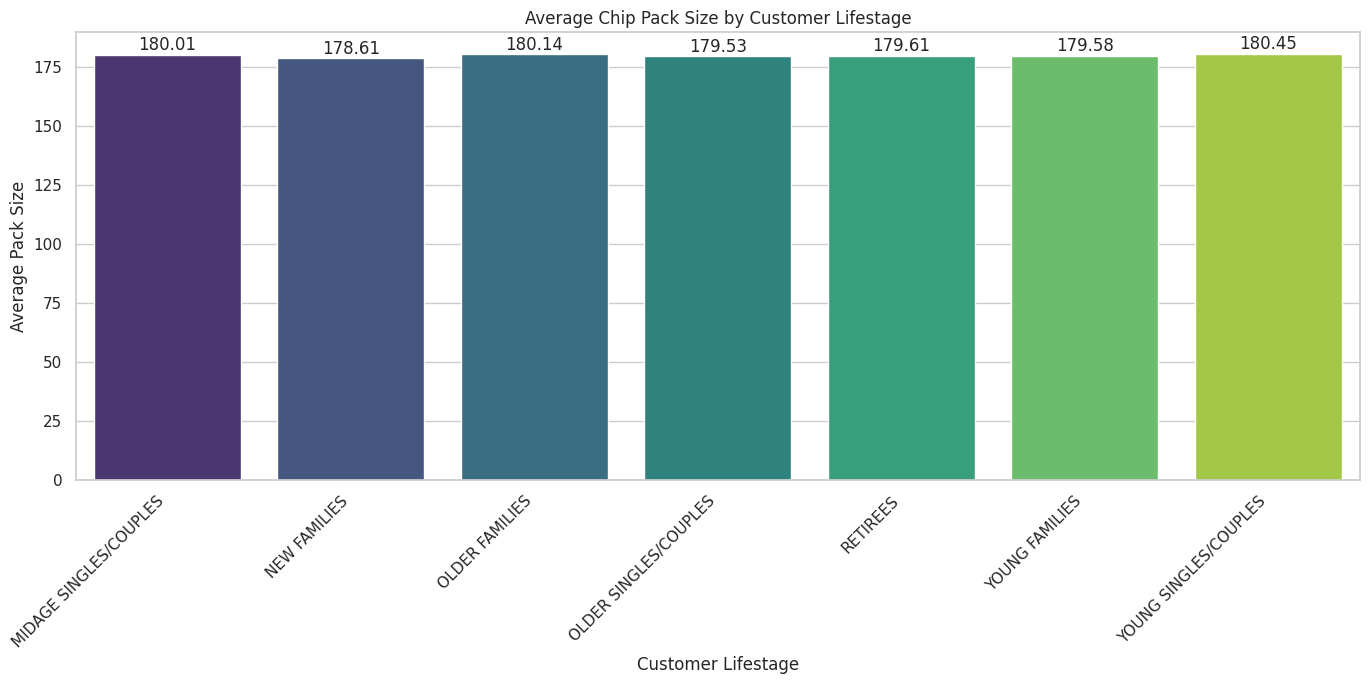

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get average pack size by lifestage
pack_size_by_lifestage = chip_products.groupby('LIFESTAGE')['PACK_SIZE'].mean().reset_index()

# Set the style for the plot
sns.set(style="whitegrid")

# Create a bar plot using seaborn
plt.figure(figsize=(14, 7))
sns.barplot(x='LIFESTAGE', y='PACK_SIZE', data=pack_size_by_lifestage, palette="viridis")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Axis labels and title
plt.xlabel('Customer Lifestage')
plt.ylabel('Average Pack Size')
plt.title('Average Chip Pack Size by Customer Lifestage')

# Annotate bars with values
for i, pack_size in enumerate(pack_size_by_lifestage['PACK_SIZE']):
    plt.text(i, pack_size + 0.1, f'{round(pack_size, 2)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()
